# Cloud Wars

##### A big data analytics exercise: batch and stream processing of twitter data

### Contents

* **0 Introduction**
* **1 Load Modules**
* **2 Data Loading, Checking and Initial Preprocessing**
* **3 Inspect Loaded data **
* **4 Pre-process Texts**
* **5 Language Detection**
* **6 Tweet Translation**
* **7 Initial Visulization**
* **8 Key Phrases Extraction**
* **9 Sentiment Extraction**
* **10 Network Analysis**
* **11 Word2Vec Models**

In [2]:
!pip install stop-words

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
!pip install pyathena

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
!pip install wordcloud

    100% |████████████████████████████████| 368kB 27.5MB/s ta 0:00:01
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# 1. Load Modules

In [1]:
import pandas as pd
from collections import OrderedDict
import requests
import boto3 
import nltk
import sys
import stop_words
from my_utils import language_dict, text_clean_alphanum, \
                    det_tweet_language, translate_tweet, \
                    athena_cursor
import seaborn as sns
from pyathena.util import as_pandas
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import sys

# 2. Load Data from Athenna

In [2]:
athena_cursor.execute("SELECT * FROM coronavirus.tweet")
tweet_text= as_pandas(athena_cursor)

# 3. Inspect Loaded Data

In [11]:
tweet_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22852 entries, 0 to 22851
Data columns (total 17 columns):
tweet_id              22852 non-null object
user_id               22852 non-null object
created_at            22852 non-null object
created_at_date       22852 non-null object
source                22852 non-null object
truncated             22852 non-null bool
text                  22852 non-null object
coordinates           51 non-null object
place_type            22852 non-null object
place_name            22852 non-null object
place_full_name       22852 non-null object
place_country         22852 non-null object
place_country_code    22852 non-null object
reply_count           22852 non-null int64
retweet_count         22852 non-null int64
favorite_count        22852 non-null int64
hashtag               22852 non-null object
dtypes: bool(1), int64(3), object(13)
memory usage: 2.8+ MB


In [12]:
# get a copy of the data 
data = tweet_text[['tweet_id', 'user_id', 'text']] .copy()

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22852 entries, 0 to 22851
Data columns (total 3 columns):
tweet_id    22852 non-null object
user_id     22852 non-null object
text        22852 non-null object
dtypes: object(3)
memory usage: 535.7+ KB


In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# 4. Pre-process Text

In [3]:
#otion 1 
data['clean_text'] = data['text'].apply(text_clean_alphanum)

data.head()

NameError: name 'data' is not defined

In [15]:
# compare some example 
print(data.iloc[0,2])
print()
print(data.iloc[0,3])

*** massive sale! *** add coupon dps10 and get 50% off when you buy over $50 of primeval labs’ amazing supps at dps nutrition! 
resolution2020 newyearsresolution

 ekxsfwcaid  nl5kuoe86k

 massive sale   add coupon dps10 get 50  buy  50 primeval labs  amazing supps dps nutrition  resolution2020 newyearsresolution ekxsfwcaid nl5kuoe86k


# 5. Detect the tweet language

In [16]:
comprehend_client = boto3.client('comprehend', region_name='eu-west-1')

In [17]:
def det_tweet_language(item):
    response = comprehend_client.detect_dominant_language(
        Text=item
    )
    return response['Languages'][0]['LanguageCode']

In [18]:
data['tweet_language'] = data['text'].apply(det_tweet_language)
data.head()

,tweet_id,user_id,text,clean_text,tweet_language
0,1212711553323147264,189148850,*** massive sale! *** add coupon dps10 and get...,massive sale add coupon dps10 get 50 buy ...,en
1,1212049646895484931,760244020589240320,goodbye 2019. you were really hard to deal wit...,goodbye 2019 really hard deal thanks learnt g...,en
2,1216400229018284033,991674300783525888,ever considered using reclaimed wood in your h...,ever considered using reclaimed wood home desi...,en
3,1212374788263596032,609376805,resolution2020 : ne plus pisser dans le lavabo...,resolution2020 ne plus pisser dans le lavabo ...,fr
4,1213421160639188998,375543266,my biggest achievement this year so far: i've ...,biggest achievement year far ve washed every ...,en


In [19]:
data.tail()

,tweet_id,user_id,text,clean_text,tweet_language
10453,1217888784513224706,982519142547935232,d.i.y. 10-second carb ritual strips away fat: ...,diy 10second carb ritual strips away fat qos...,en
10454,1180923439223324676,2836276353,i’ve given my voicefortheplanet to call for a ...,ve given voicefortheplanet call newdealfornat...,en
10455,1179901379072200704,23371841,link to the report:\n\n tmb5m6grj5\n\nnewdealf...,link report tmb5m6grj5 newdealfornature voice...,en
10456,1179773145647124482,19533083,i’ve given my voicefortheplanet to call for a ...,ve given voicefortheplanet call newdealfornat...,en
10457,1200120951020515329,2434246441,i’ve given my voicefortheplanet to call for a ...,ve given voicefortheplanet call newdealfornat...,en


In [20]:
data['tweet_language_full'] = data['tweet_language'].apply(lambda x : language_dict[x])

data.head()

,tweet_id,user_id,text,clean_text,tweet_language,tweet_language_full
0,1212711553323147264,189148850,*** massive sale! *** add coupon dps10 and get...,massive sale add coupon dps10 get 50 buy ...,en,English
1,1212049646895484931,760244020589240320,goodbye 2019. you were really hard to deal wit...,goodbye 2019 really hard deal thanks learnt g...,en,English
2,1216400229018284033,991674300783525888,ever considered using reclaimed wood in your h...,ever considered using reclaimed wood home desi...,en,English
3,1212374788263596032,609376805,resolution2020 : ne plus pisser dans le lavabo...,resolution2020 ne plus pisser dans le lavabo ...,fr,French
4,1213421160639188998,375543266,my biggest achievement this year so far: i've ...,biggest achievement year far ve washed every ...,en,English


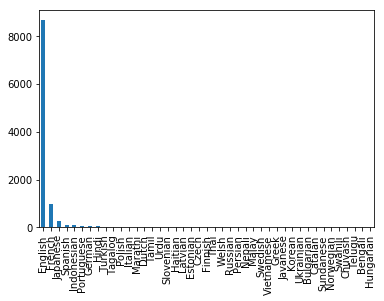

In [21]:
# create a distribution plot of the tweet languages 
data['tweet_language_full'].value_counts().plot(kind='bar')

# 6. Translate non-English tweets to English

In [22]:
data['translated_text'] = data.apply(translate_tweet, axis=1)

In [23]:
data.head()

,tweet_id,user_id,text,clean_text,tweet_language,tweet_language_full,translated_text
0,1212711553323147264,189148850,*** massive sale! *** add coupon dps10 and get...,massive sale add coupon dps10 get 50 buy ...,en,English,massive sale add coupon dps10 get 50 buy ...
1,1212049646895484931,760244020589240320,goodbye 2019. you were really hard to deal wit...,goodbye 2019 really hard deal thanks learnt g...,en,English,goodbye 2019 really hard deal thanks learnt g...
2,1216400229018284033,991674300783525888,ever considered using reclaimed wood in your h...,ever considered using reclaimed wood home desi...,en,English,ever considered using reclaimed wood home desi...
3,1212374788263596032,609376805,resolution2020 : ne plus pisser dans le lavabo...,resolution2020 ne plus pisser dans le lavabo ...,fr,French,resolution2020 no longer pee in the washbasin ...
4,1213421160639188998,375543266,my biggest achievement this year so far: i've ...,biggest achievement year far ve washed every ...,en,English,biggest achievement year far ve washed every ...


In [24]:
data.tail()

,tweet_id,user_id,text,clean_text,tweet_language,tweet_language_full,translated_text
10453,1217888784513224706,982519142547935232,d.i.y. 10-second carb ritual strips away fat: ...,diy 10second carb ritual strips away fat qos...,en,English,diy 10second carb ritual strips away fat qos...
10454,1180923439223324676,2836276353,i’ve given my voicefortheplanet to call for a ...,ve given voicefortheplanet call newdealfornat...,en,English,ve given voicefortheplanet call newdealfornat...
10455,1179901379072200704,23371841,link to the report:\n\n tmb5m6grj5\n\nnewdealf...,link report tmb5m6grj5 newdealfornature voice...,en,English,link report tmb5m6grj5 newdealfornature voice...
10456,1179773145647124482,19533083,i’ve given my voicefortheplanet to call for a ...,ve given voicefortheplanet call newdealfornat...,en,English,ve given voicefortheplanet call newdealfornat...
10457,1200120951020515329,2434246441,i’ve given my voicefortheplanet to call for a ...,ve given voicefortheplanet call newdealfornat...,en,English,ve given voicefortheplanet call newdealfornat...


# 7. Create some word clouds

In [17]:
# prepare the data for word cloud
text = data['text'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    max_words=500,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))

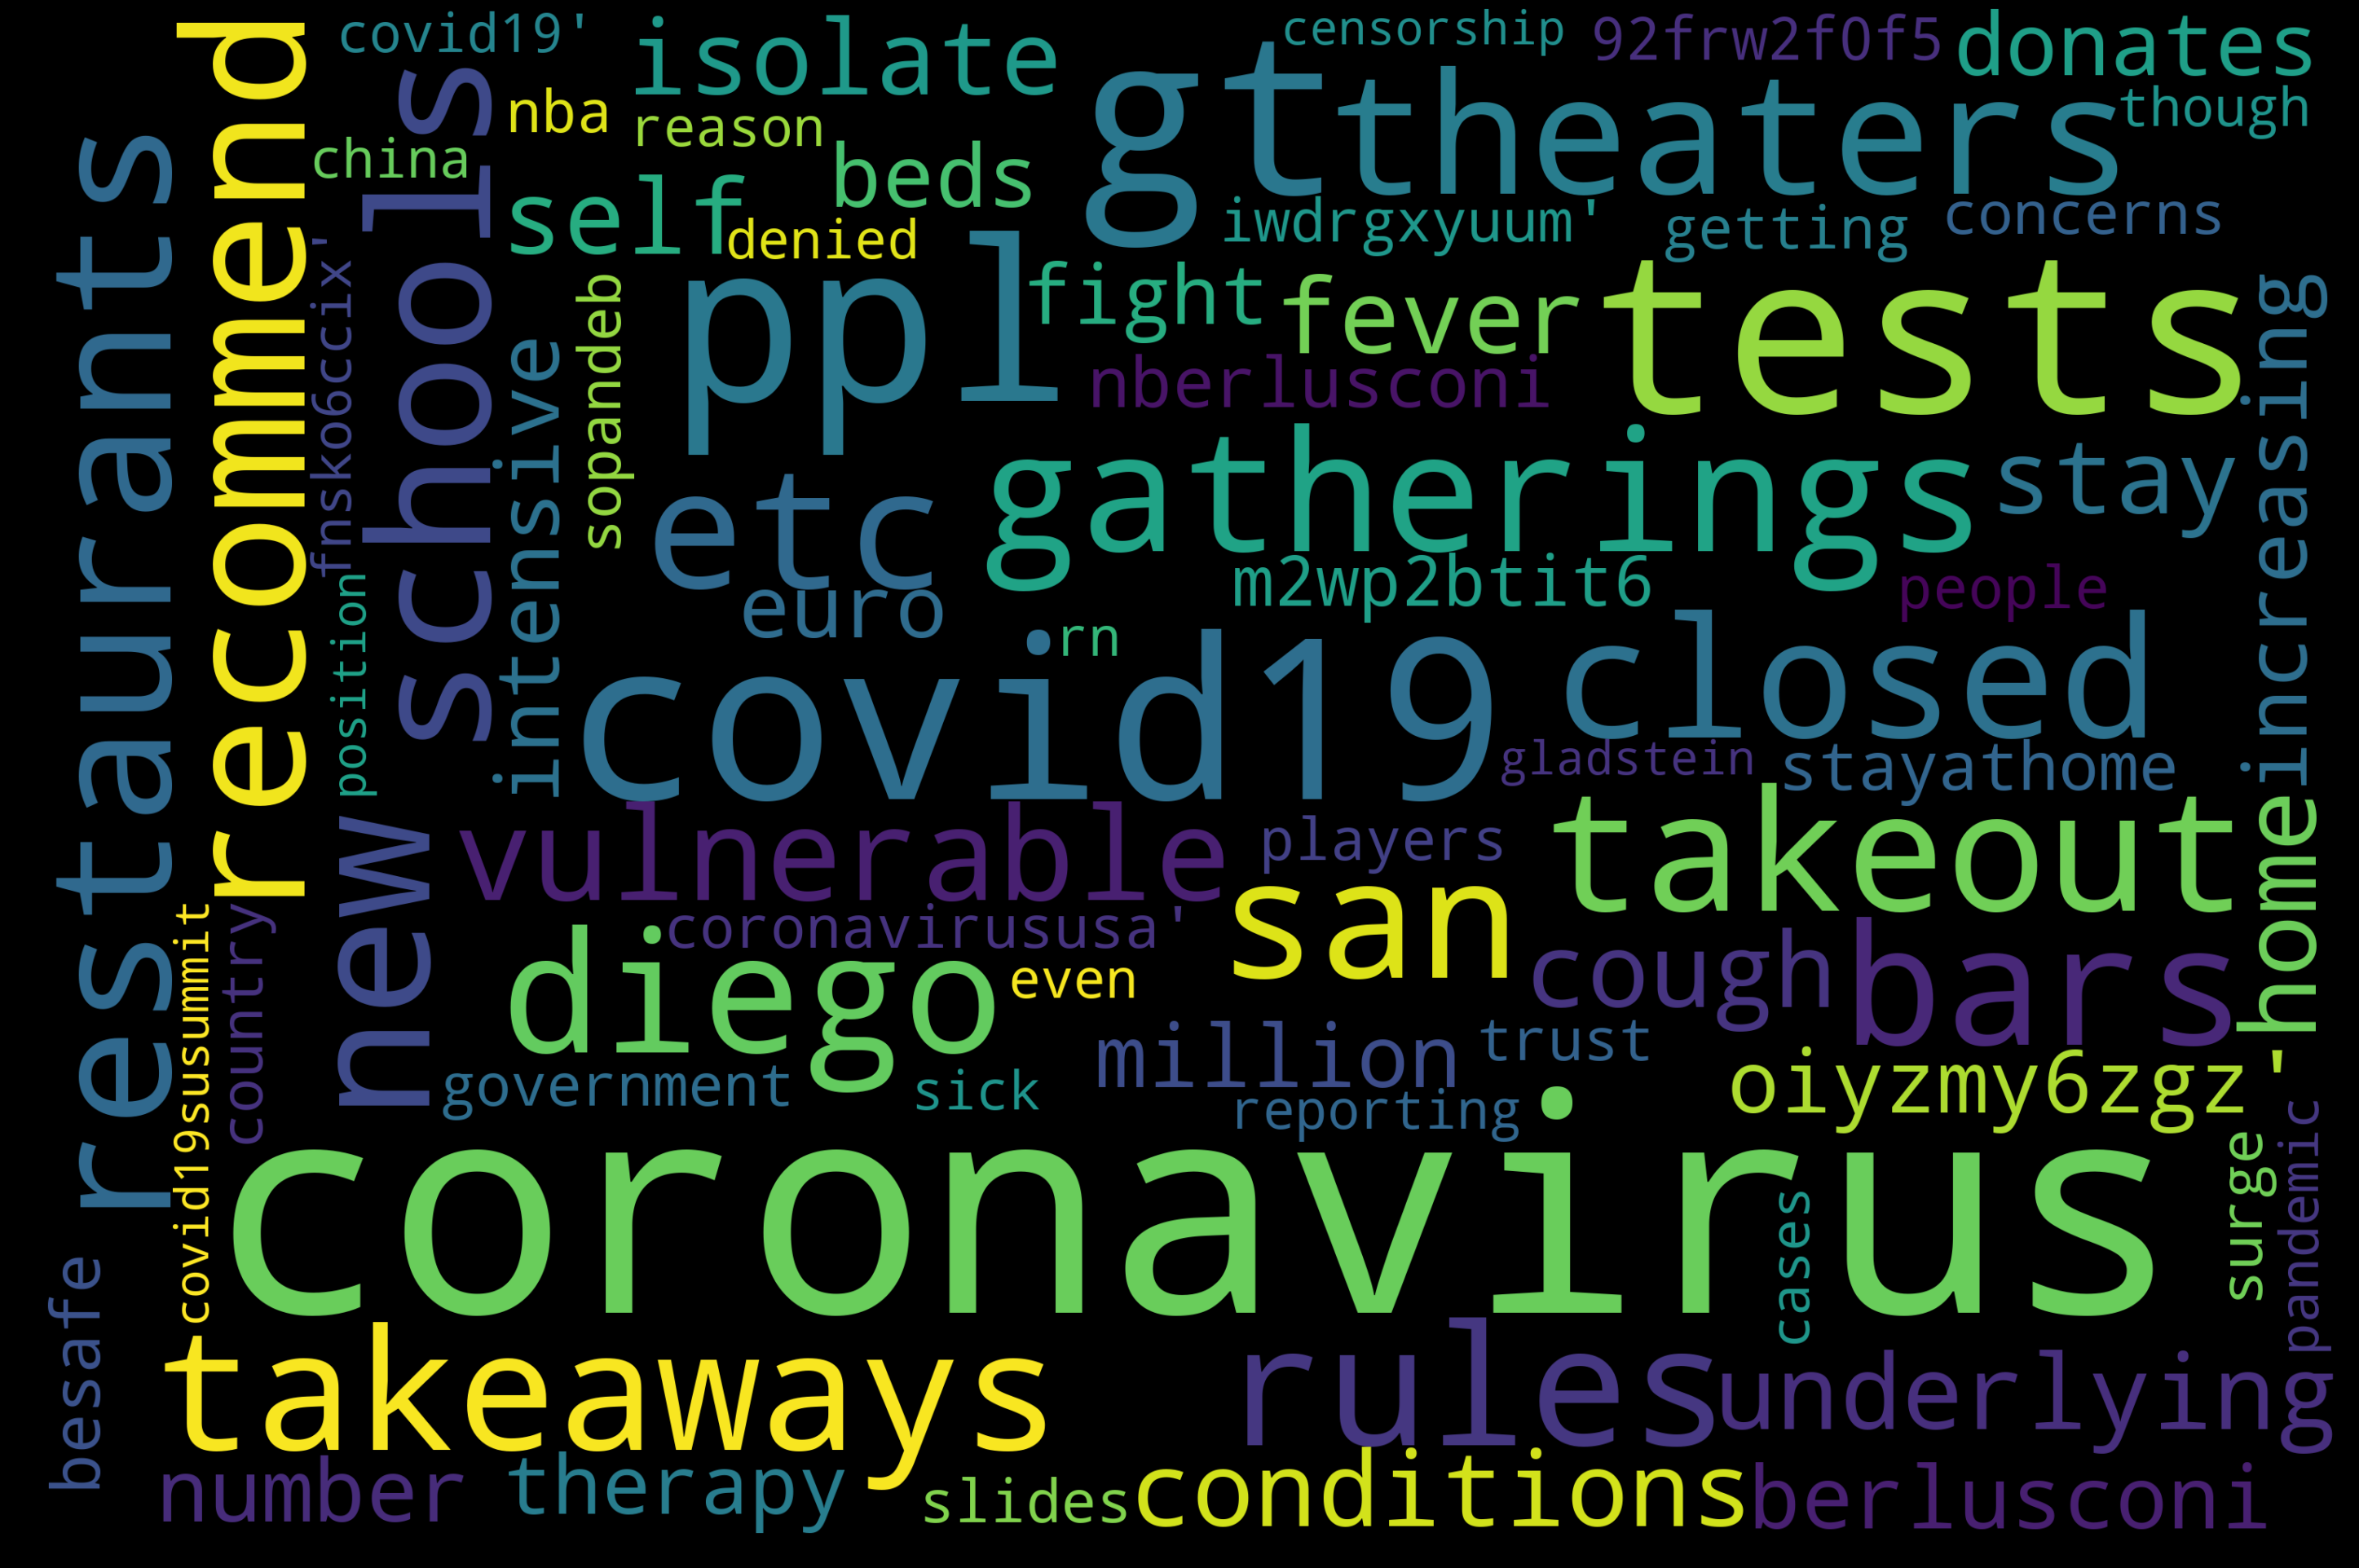

In [18]:
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# 8. Extract and Display Key Phrases

In [27]:
def extract_key_phrases(text):
    key_phr = comprehend_client.detect_key_phrases(Text=text, LanguageCode='en')
    key_phr = ' '.join(x for x in [e['Text'] for e in key_phr['KeyPhrases']] )

    return key_phr

In [38]:
data['key_phrases'] = data['translated_text'].apply(extract_key_phrases)

data.head()

,tweet_id,user_id,text,clean_text,tweet_language,tweet_language_full,translated_text,key_phrases,Sentiment
0,1212711553323147264,189148850,*** massive sale! *** add coupon dps10 and get...,massive sale add coupon dps10 get 50 buy ...,en,English,massive sale add coupon dps10 get 50 buy ...,massive sale coupon dps10 50 50 primeval labs ...,NEUTRAL
1,1212049646895484931,760244020589240320,goodbye 2019. you were really hard to deal wit...,goodbye 2019 really hard deal thanks learnt g...,en,English,goodbye 2019 really hard deal thanks learnt g...,2019 really hard deal 2020 new friends stories...,NEUTRAL
2,1216400229018284033,991674300783525888,ever considered using reclaimed wood in your h...,ever considered using reclaimed wood home desi...,en,English,ever considered using reclaimed wood home desi...,reclaimed wood home design environment home ch...,NEUTRAL
3,1212374788263596032,609376805,resolution2020 : ne plus pisser dans le lavabo...,resolution2020 ne plus pisser dans le lavabo ...,fr,French,resolution2020 no longer pee in the washbasin ...,resolution2020,NEUTRAL
4,1213421160639188998,375543266,my biggest achievement this year so far: i've ...,biggest achievement year far ve washed every ...,en,English,biggest achievement year far ve washed every ...,biggest achievement year every day,POSITIVE


In [39]:
# prepare the data for word cloud
kp_text = data['key_phrases'].values
kp_wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    max_words=500,
    stopwords = STOPWORDS).generate(str(kp_text))

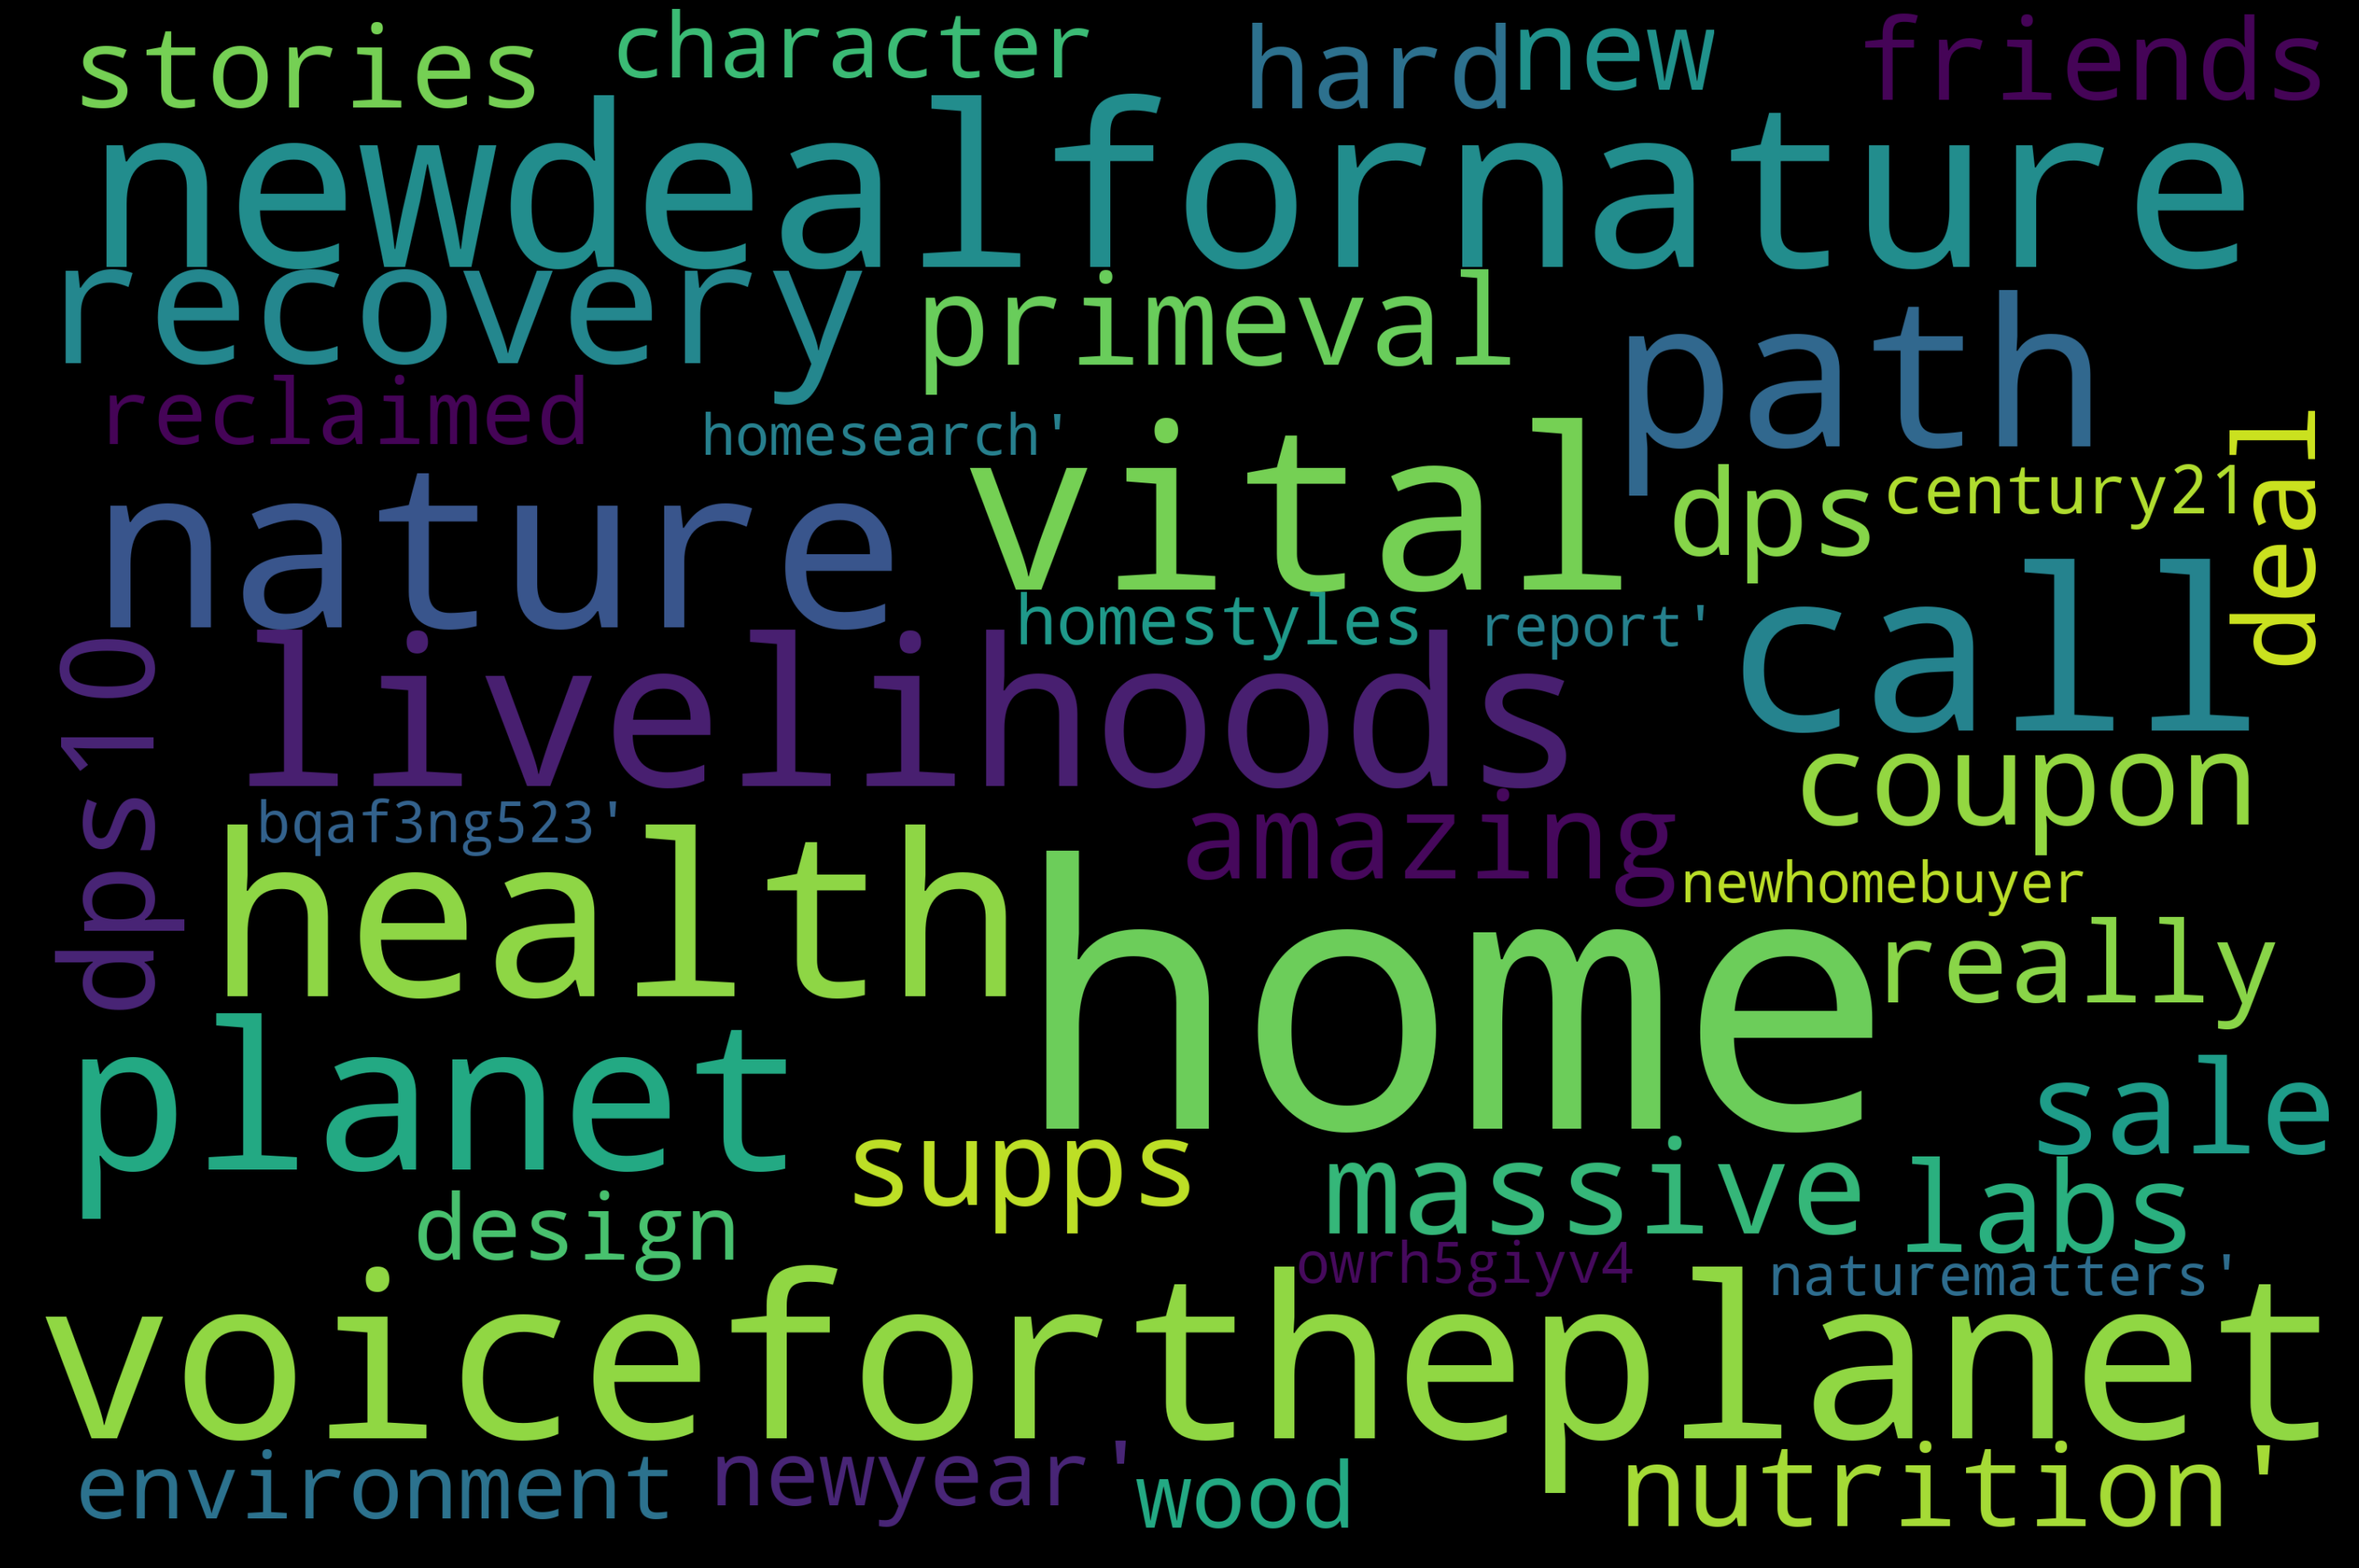

In [40]:
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(kp_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# 9. Extract Sentiments

In [21]:
all_sentiments = []
comprehend_client = boto3.client('comprehend', region_name='eu-west-1', use_ssl=True)
def extract_sentiment(text):
    text_sentiments = comprehend_client.detect_sentiment(Text=text, LanguageCode='en')
    all_sentiments.append(text_sentiments['SentimentScore'])
    return text_sentiments['Sentiment']

In [22]:
#data['Sentiment'] =data['translated_text'].apply(extract_sentiment)
#applying to the uncleansed text
data['Sentiment'] =data['text'].apply(extract_sentiment)

In [24]:
data.head()

,tweet_id,user_id,text,Sentiment
0,1240006523809435648,825852244369104896,new covid19 rules for san diego. some takeaway...,NEUTRAL
1,1240003141359329280,935902959237521414,berlusconi donates 10 million euro for increas...,NEUTRAL
2,1240035327542165514,43525639,"92frw2f0f5 u.s. coronavirus concerns surge, g...",NEUTRAL
3,1240035374501593088,3038946555,light-heartedness...,NEUTRAL
4,1240006041741426691,790546093,"in late-2007, pfizer announced it wd offshore ...",NEUTRAL


In [26]:
sentiment_data=data.copy()

In [29]:
sentiment_data.head(10)

,tweet_id,user_id,text,Sentiment
0,1240006523809435648,825852244369104896,new covid19 rules for san diego. some takeaway...,NEUTRAL
1,1240003141359329280,935902959237521414,berlusconi donates 10 million euro for increas...,NEUTRAL
2,1240035327542165514,43525639,"92frw2f0f5 u.s. coronavirus concerns surge, g...",NEUTRAL
3,1240035374501593088,3038946555,light-heartedness...,NEUTRAL
4,1240006041741426691,790546093,"in late-2007, pfizer announced it wd offshore ...",NEUTRAL
5,1240006235904249856,1195016412693172224,with everyone spending all this time at home i...,NEGATIVE
6,1240006265444524032,415209332,but myer sent out emails saying they’re open f...,NEUTRAL
7,1240006281592737793,4841208039,who conference on 16th march about corona rea...,NEUTRAL
8,1240004220037795843,1058088499260391426,thorpepark and altontowers have updated their ...,NEUTRAL
9,1240036304651538432,863520324,so officedepot sent two emails promising that ...,NEGATIVE


In [30]:
sentiment_df = sentiment_data[['tweet_id', 'Sentiment']].copy()

In [31]:
from io import StringIO
import boto3

def write_pd_s3_csv(df, bucket, filepath):
    csv_buffer = StringIO()
    df.to_csv(csv_buffer)
    s3_resource = boto3.resource('s3')
    s3_resource.Object(bucket, filepath).put(Body=csv_buffer.getvalue())
    print("The data is successfully written to S3 path:", bucket+"/"+filepath)

# Write to S3
s3_bucket =  'tweet-general'  
file_path = 'corona/sentiment/sentiment.csv'
tweet_text = sentiment_df
write_pd_s3_csv(tweet_text, s3_bucket, file_path)

The data is successfully written to S3 path: tweet-general/corona/sentiment/sentiment.csv


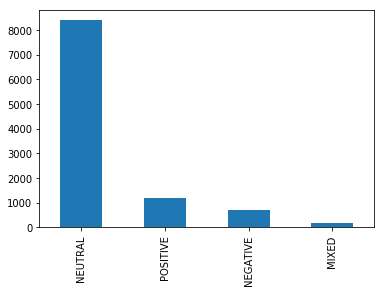

In [44]:
# create a distribution plot of the sentiments
data['Sentiment'].value_counts().plot(kind='bar')

In [45]:
data.to_csv('tweets_clean_with_sentiments_full.csv', index=False)

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10458 entries, 0 to 10457
Data columns (total 9 columns):
tweet_id               10458 non-null object
user_id                10458 non-null object
text                   10458 non-null object
clean_text             10458 non-null object
tweet_language         10458 non-null object
tweet_language_full    10458 non-null object
translated_text        10458 non-null object
key_phrases            10458 non-null object
Sentiment              10458 non-null object
dtypes: object(9)
memory usage: 735.4+ KB


In [47]:
from io import StringIO
import boto3

def write_pd_s3_csv(df, bucket, filepath):
    csv_buffer = StringIO()
    df.to_csv(csv_buffer)
    s3_resource = boto3.resource('s3')
    s3_resource.Object(bucket, filepath).put(Body=csv_buffer.getvalue())
    print("The data is successfully written to S3 path:", bucket+"/"+filepath)

# Write to S3
s3_bucket =  'tweet-general'  
file_path = 'new_tables/clean_data/tweets_clean_with_sentiments_full.csv'
tweet_text = data
write_pd_s3_csv(tweet_text, s3_bucket, file_path)

The data is successfully written to S3 path: tweet-general/new_tables/clean_data/tweets_clean_with_sentiments_full.csv


In [48]:
tweet_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10458 entries, 0 to 10457
Data columns (total 9 columns):
tweet_id               10458 non-null object
user_id                10458 non-null object
text                   10458 non-null object
clean_text             10458 non-null object
tweet_language         10458 non-null object
tweet_language_full    10458 non-null object
translated_text        10458 non-null object
key_phrases            10458 non-null object
Sentiment              10458 non-null object
dtypes: object(9)
memory usage: 735.4+ KB


In [49]:
# get a copy of the data 
athena_cursor.execute("SELECT * FROM twitter_sentiment_analysis.tweet")
data_twin = as_pandas(athena_cursor)

In [50]:
data_twin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10458 entries, 0 to 10457
Data columns (total 17 columns):
tweet_id              10458 non-null object
user_id               10458 non-null object
created_at            10458 non-null object
created_at_date       10458 non-null object
source                10458 non-null object
truncated             10458 non-null bool
text                  10458 non-null object
coordinates           57 non-null object
place_type            10458 non-null object
place_name            10458 non-null object
place_full_name       10458 non-null object
place_country         10458 non-null object
place_country_code    10458 non-null object
reply_count           10458 non-null int64
retweet_count         10458 non-null int64
favorite_count        10458 non-null int64
hashtag               10458 non-null object
dtypes: bool(1), int64(3), object(13)
memory usage: 1.3+ MB


In [51]:
data_twin.head()

,tweet_id,user_id,created_at,created_at_date,source,truncated,text,coordinates,place_type,place_name,place_full_name,place_country,place_country_code,reply_count,retweet_count,favorite_count,hashtag
0,1213490028439101440,345290070,Sat Jan 04 15:59:02 +0000 2020,"Jan 04, 2020",Twitter for Android,True,danielc68749467 birdspernicious jillwintermusi...,None,,,,,,0,1,5,Resolution2020
1,1213590098228523009,1062472486028238848,Sat Jan 04 22:36:41 +0000 2020,"Jan 04, 2020",Twitter for iPhone,False,parfois bosser un samedi soir ça pique un peu ...,None,,,,,,0,0,1,Resolution2020
2,1213569552984027136,971160055168028672,Sat Jan 04 21:15:03 +0000 2020,"Jan 04, 2020",Sprout Social,True,start 2020 off right with some easy to keep re...,None,,,,,,0,0,1,Resolution2020
3,1212052481611620354,42864231,Tue Dec 31 16:46:45 +0000 2019,"Dec 31, 2019",Twitter for iPhone,True,i got your resolution2020 right here: dtc967x...,None,,,,,,0,0,0,Resolution2020
4,1212401295312793601,118822739,Wed Jan 01 15:52:48 +0000 2020,"Jan 01, 2020",Twitter for iPhone,True,resolution2020\nil faut en finir avec certaine...,None,,,,,,1,0,4,Resolution2020
